# Qarameterized circuits
**Evan Peters**, University of Waterloo, Institute for Quantum Computing  
**Prasanth Shyamsundar**, Fermi National Accelerator Laboratory, Fermilab Quantum Institute

In [1]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.colors import LogNorm

In [2]:
plt.rcParams.update({'font.size': 16})

## Implementation

### 1. Random circuit parameterized by classical parameters and control quantum registers:
The class of random circuits used in this notebook is from [pennylane.ai/qml/demos/tutorial_barren_plateaus.html](https://pennylane.ai/qml/demos/tutorial_barren_plateaus.html). Some parameters of the circuit are elevated to be represented by quantum registers:
$$A(\theta_\mathrm{c})\Big[\big|0\big\rangle \otimes \big|\theta_\mathrm{q}\big\rangle_\mathrm{ctrl}\Big] = \big|\psi(\theta_\mathrm{c},\theta_\mathrm{q})\big\rangle \otimes \big|\theta_\mathrm{q}\big\rangle_\mathrm{ctrl}$$
The basis states of the control register (for a single parameter $\theta_{\mathrm{q}i}$), namely $\big\{\big|0\big\rangle_\mathrm{ctrl}, \big|1\big\rangle_\mathrm{ctrl}, \dots\big\}$, correspond to discretized values for $\theta_{\mathrm{q}i}$ in the range $[0, 2\pi)$.  
This is implemented in `RandomCircuit.rand_circuit` (based on Appendix E of Ref. [[1]](https://arxiv.org/abs/2102.04975)).

### 2. Oracle to evaluate the state of the control registers:
The state $\big|\psi(\theta_\mathrm{c},\theta_\mathrm{q})\big\rangle$ can be written in terms of two projections:
$$\big|\psi(\theta_\mathrm{c},\theta_\mathrm{q})\big\rangle = \frac{1}{\sqrt{2}}\Big[\big|\eta_+(\theta_\mathrm{c},\theta_\mathrm{q})\big\rangle - \big|\eta_-(\theta_\mathrm{c},\theta_\mathrm{q})\big\rangle\Big]$$

$U(\theta_\mathrm{c})$ is a quantum oracle, whose action is as follows:
$$U(\theta_\mathrm{c})\Big[\big|\eta_\pm(\theta_\mathrm{c},\theta_\mathrm{q})\big\rangle \otimes \big|\theta_\mathrm{q}\big\rangle_\mathrm{ctrl}\Big] = \exp{\big(\pm i\varphi(\theta_\mathrm{c}, \theta_\mathrm{q})\big)}\Big[\big|\eta_\pm(\theta_\mathrm{c},\theta_\mathrm{q})\big\rangle \otimes \big|\theta_\mathrm{q}\big\rangle_\mathrm{ctrl}\Big]$$
where
$$\cos\big(\varphi(\theta_\mathrm{c},\theta_\mathrm{q})\big) = 2\ \Big|\big\langle\psi(\theta_\mathrm{c},\theta_\mathrm{q})\big|0\big\rangle\Big|^2 - 1$$

The oracle evaluates the state of the control register(s) $\big|\theta_\mathrm{q}\big\rangle_\mathrm{ctrl}$, and applies a control-state-dependent phase based on the value of $\Big|\big\langle\psi(\theta_\mathrm{c},\theta_\mathrm{q})\big|0\big\rangle\Big|$.  
This is implemented in `RandomCircit.oracle` (based loosely on Section 6.2 and Appendix E of Ref. [[1]](https://arxiv.org/abs/2102.04975))

### 3. Non-Boolean Amplitude Amplification
* The control registers are initialized to a uniform super position state.
* The different basis states of the control registers are preferentially amplified, based on $\cos(\varphi)$.  
  Here, the states with higher values of $\cos(\varphi)$ are preferred (in Ref. [[1]](https://arxiv.org/abs/2102.04975), lower values of $\cos(\varphi)$ are preferred).  
* The control registers are measured post-amplification. The good basis states will have higher measurement probabilities.

This is implemented in `RandomCircuit.make_amplitude_amplification_circuit` (based on Sections 2 and 6.1 of Ref. [[1]](https://arxiv.org/abs/2102.04975))

[1] Prasanth Shyamsundar, _"Non-Boolean Quantum Amplitude Amplification and Quantum Mean Estimation"_ (2018), [arXiv:2102.04975 [quant-ph]](https://arxiv.org/abs/2102.04975).

In [3]:
class RandomCircuit:
    gate_set = [qml.RX, qml.RY, qml.RZ]
    ctrl_gate_set = [qml.CRX, qml.CRY, qml.CRZ]
    
    def __init__(self, num_qubits, precision_qparams=5, max_qparams=2*np.pi,
                 include_max=False, random_gateidx_sequence=None, seed=None):
        self.num_qubits = self.num_params = num_qubits
        self.precision_qparams = precision_qparams
        self.max_qparams = max_qparams
        
        self.num_bins = 2**precision_qparams
        if include_max:
            self.num_bins -= 1
        
        if random_gateidx_sequence is None:
            if seed is not None:
                np.random.seed(seed)
            self.random_gateidx_sequence = np.random.choice(3, self.num_params)
        else:
            self.random_gateidx_sequence = random_gateidx_sequence
        
        self.__init_target_prob__()
    
    # Random circuit parameterized by `num_qparams` control quantum registers ############
    # Each control register has `precision_qparams` qubits. ##############################
    @qml.template
    def rand_circuit(self, cparams, num_qparams):
        num_cparams = self.num_params - num_qparams # Numbers of classical and "quantum" parameters
        
        # Wires:
        #   First `num_qubits` wires form the main register.
        #   After that, every `precision_qparams` wires coresponds to one qparam.
        
        num_wires = self.num_qubits + num_qparams*self.precision_qparams
        
        for i in range(self.num_qubits):
            qml.RY(np.pi/4, wires=i)
        
        for i in range(num_cparams):
            self.gate_set[self.random_gateidx_sequence[i]](cparams[i], wires=i)
        
        for i in range(num_cparams, self.num_params):
            ctrl_gate = self.ctrl_gate_set[self.random_gateidx_sequence[i]]
            for j in range(self.precision_qparams):
                ctrl_wire = self.num_qubits + (i-num_cparams)*self.precision_qparams + j
                
                #j = 0 is the least significant
                ctrl_angle = self.max_qparams*2**(self.precision_qparams-j-1) / self.num_bins
                
                ctrl_gate(ctrl_angle, wires=[ctrl_wire, i])
        
        for i in range(self.num_qubits-1):
            qml.CZ(wires=[i, i+1])
    ######################################################################################
    
    def __init_target_prob__(self):
        @qml.qnode(qml.device('default.qubit', wires=self.num_qubits))
        def func(cparams):
            self.rand_circuit(cparams, num_qparams=0)
            
            H = np.zeros((2**self.num_qubits, 2**self.num_qubits))
            H[0, 0] = 1
            return qml.expval(qml.Hermitian(H, wires=range(self.num_qubits)))
        self.target_prob = func
    
    # Quantum oracle to evaluate the state of the control registers ######################
    @qml.template
    def oracle(self, cparams, num_qparams):
        diag = np.ones(2**self.num_qubits)
        diag[0] *= -1
        
        qml.DiagonalQubitUnitary(diag, wires=range(self.num_qubits))
        qml.inv(self.rand_circuit(cparams, num_qparams))
        
        qml.DiagonalQubitUnitary(diag, wires=range(self.num_qubits))
        self.rand_circuit(cparams, num_qparams)
    ######################################################################################
    
    # Non-Boolean Amplitude Amplification ################################################
    def make_amplitude_amplification_circuit(self, num_qparams, K):
        assert num_qparams <= self.num_params
        num_wires = self.num_qubits + num_qparams*self.precision_qparams
        
        @qml.template
        def init_circuit(cparams):
            # Initialize control registers to a uniform superposition state
            for i in range(self.num_qubits, num_wires):
                qml.Hadamard(wires=i)
            
            # Couple the control registers to main register (initialize main register basedon the state of the control)
            self.rand_circuit(cparams, num_qparams)
        
        # Amplification circuit ############################
        @qml.qnode(qml.device('default.qubit', wires=num_wires))
        def circuit(cparams):
            diag = np.ones(2**num_wires)
            diag[0] *= -1
            
            # Initialization
            init_circuit(cparams)
            
            # Non-Boolean Amplitude Amplification go brrrrr
            for k in range(1, K+1):
                # Act the oracle during odd iterations, or its inverse during the even iterations
                if k%2 == 1:
                    self.oracle(cparams, num_qparams)
                else:
                    qml.inv(self.oracle(cparams, num_qparams))
                
                # Diffusion operator
                qml.inv(init_circuit(cparams))
                qml.DiagonalQubitUnitary(diag, wires=range(num_wires))
                init_circuit(cparams)
            
            # Measurement of the control registers post amplification
            return qml.probs(wires=range(self.num_qubits, num_wires))
        ####################################################
        
        # Computing the amplified probabilities ############
        def probs_func(cparams):
            probs = circuit(cparams)
            probs_dict = {}
            for i in range(len(probs)):
                tmp, key = i, []
                for j in range(num_qparams):
                    key.append(tmp % 2**self.precision_qparams)
                    tmp //= 2**self.precision_qparams
                
                key = tuple(key)
                probs_dict[key] = float(probs[i])
            return probs_dict
        
        return circuit, probs_func
        ####################################################

## Create a RandomCircuit object

In [4]:
NUM_QUBITS = 2
PRECISION = 5
SEED = 1

rc = RandomCircuit(num_qubits=NUM_QUBITS, precision_qparams=PRECISION, seed=SEED)

### Case 1: All parameters classical
Circuit for `SEED=1`:

<img src="img/cparam_circuit.png" width=350 />

`rc.target_prob` computes the probability for a measurement on $\big|\psi(\theta_{\mathrm{c}0}, \theta_{\mathrm{c}1})\big\rangle$ to yield the target state $\big|0\big\rangle$, i.e.,
$$\mathrm{score} = \Big|\big\langle\psi(\theta_{\mathrm{c}0}, \theta_{\mathrm{c}1})\big|0\big\rangle\Big|^2$$
A heatmap is created to show the dependence of this score function on the parameters $(\theta_{\mathrm{c}0},\theta_{\mathrm{c}1})$.

In [5]:
max_param = 2*np.pi
binwidth = 2*np.pi/2**PRECISION

# Bottom-left corner is the representative value for each cell
cparam_0_binedges = np.linspace(0, 2*np.pi, num=2**PRECISION+1, endpoint=True)
cparam_1_binedges = np.linspace(0, 2*np.pi, num=2**PRECISION+1, endpoint=True)
cparam_0_binedges, cparam_1_binedges = np.meshgrid(cparam_0_binedges, cparam_1_binedges)

cparam_0_vals = np.linspace(0, 2*np.pi, num=2**PRECISION, endpoint=False)
cparam_1_vals = np.linspace(0, 2*np.pi, num=2**PRECISION, endpoint=False)
cparam_0_vals, cparam_1_vals = np.meshgrid(cparam_0_vals, cparam_1_vals)

score_landscape = np.zeros_like(cparam_0_vals)
for idx in np.ndindex(cparam_0_vals.shape):
    score_landscape[idx] = rc.target_prob([cparam_0_vals[idx], cparam_1_vals[idx]])

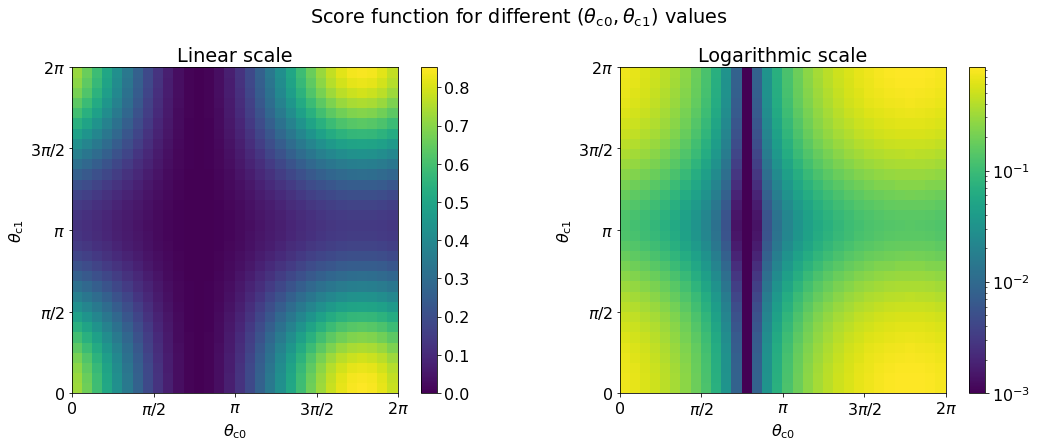

In [6]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(18, 6))

_ = ax0.pcolormesh(cparam_0_binedges, cparam_1_binedges, score_landscape)
plt.colorbar(_, ax=ax0)
ax0.set_aspect('equal')
ax0.set_title("Linear scale")

_ = ax1.pcolormesh(cparam_0_binedges, cparam_1_binedges, score_landscape, norm=LogNorm(vmin=1e-3))
plt.colorbar(_, ax=ax1)
ax1.set_aspect('equal')
ax1.set_title("Logarithmic scale")

for ax in [ax0, ax1]:
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_xlabel(r'$\theta_{\mathrm{c}0}$')
    ax.set_ylabel(r'$\theta_{\mathrm{c}1}$')

fig.suptitle(r"Score function for different $(\theta_{\mathrm{c}0}, \theta_{\mathrm{c}1})$ values", y=1.02)
None

### Case 2: All parameters quantum

We elevate the classical parameters to quantum registers. The computation basis states of the control registers correspond to different discretized values of the rotation angles in the range $[0, 2\pi)$. Circuit for `SEED=1`:

<img src="img/qparam_circuit.png" width=900 />

#### Number of iterations of amplitude amplification to perform
$$K = \Big\lfloor\frac{\pi}{2(\pi-\Phi)}\Big\rfloor$$
where
$$\cos(\Phi) = E_{\theta_\mathrm{q}} \big[\cos(\varphi)\big] = E_{\theta_\mathrm{q}} \left[2\ \Big|\big\langle\psi(\theta_\mathrm{q})\big|0\big\rangle\Big|^2 - 1\right]$$

In [7]:
np.random.seed(0)
N = 50
target_prob_list = [rc.target_prob([np.random.uniform(low=0, high=2*np.pi) for j in range(NUM_QUBITS)]) for _ in range(N)]
cosphi_list = [2*p - 1 for p in target_prob_list]
cosPhi, cosPhi_error = np.mean(cosphi_list), np.std(cosphi_list)/np.sqrt(N)
Phi = np.arccos(cosPhi)

K = int(np.pi/(2*(np.pi-Phi)))
print(f"{K = }")

K = 1


$K$ iterations of the amplification algorithm are performed.  
The final measurement probabilities of the quantum parameters $(\theta_{\mathrm{q}0},\theta_{\mathrm{q}1})$ are plotted as heatmaps.  
Note that the probabilities of "good" values of $(\theta_{\mathrm{q}0},\theta_{\mathrm{q}1})$ have been amplified.

In [8]:
ampl_circuit, ampl_prob_func = rc.make_amplitude_amplification_circuit(num_qparams=2, K=K)
amplified_probs = ampl_prob_func(cparams=[])

In [9]:
max_param = 2*np.pi
binwidth = 2*np.pi/2**PRECISION

# Bottom-left corner is the representative value for each cell
qparam_0_binedges = np.linspace(0, 2*np.pi, num=2**PRECISION+1, endpoint=True)
qparam_1_binedges = np.linspace(0, 2*np.pi, num=2**PRECISION+1, endpoint=True)
qparam_0_binedges, qparam_1_binedges = np.meshgrid(qparam_0_binedges, qparam_1_binedges)

qparam_0_vals = np.linspace(0, 2*np.pi, num=2**PRECISION, endpoint=False)
qparam_1_vals = np.linspace(0, 2*np.pi, num=2**PRECISION, endpoint=False)
qparam_0_vals, qparam_1_vals = np.meshgrid(qparam_0_vals, qparam_1_vals)

amplified_probs_grid = np.zeros_like(qparam_0_vals)
for idx in np.ndindex(qparam_0_vals.shape):
    amplified_probs_grid[idx] = amplified_probs[idx]

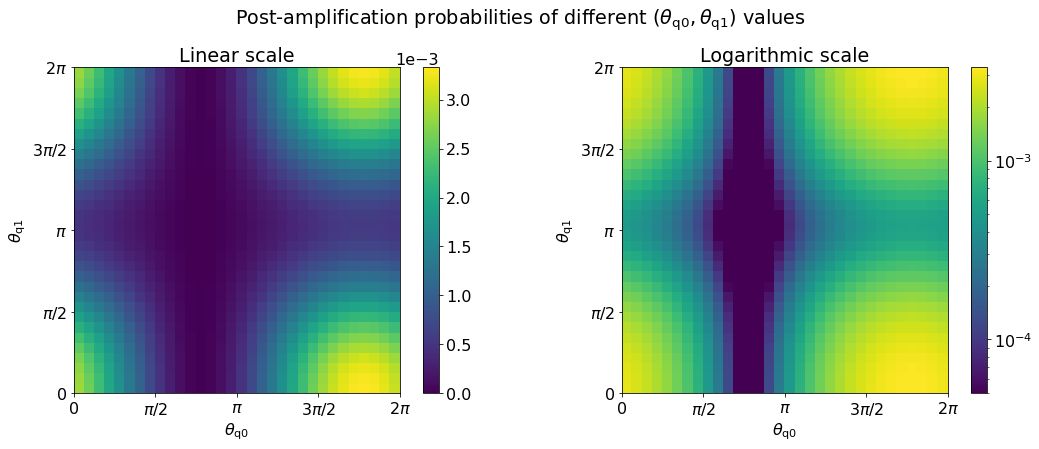

In [10]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(18, 6))

_ = ax0.pcolormesh(qparam_0_binedges, qparam_1_binedges, amplified_probs_grid)
cbar = plt.colorbar(_, ax=ax0)
cbar.formatter.set_powerlimits((0, 0))
ax0.set_aspect('equal')
ax0.set_title("Linear scale")

_ = ax1.pcolormesh(qparam_0_binedges, qparam_1_binedges, amplified_probs_grid, norm=LogNorm(vmin=5e-5))
plt.colorbar(_, ax=ax1)
ax1.set_aspect('equal')
ax1.set_title("Logarithmic scale")

for ax in [ax0, ax1]:
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_xlabel(r'$\theta_{\mathrm{q}0}$')
    ax.set_ylabel(r'$\theta_{\mathrm{q}1}$')

fig.suptitle(r"Post-amplification probabilities of different $(\theta_{\mathrm{q}0}, \theta_{\mathrm{q}1})$ values", y=1.02)
None